# 1. Import libraries

In [31]:
%matplotlib inline

import pandas as pd 
import math
import matplotlib.pyplot as plt 
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema

# 2. Change the working directory

In [32]:
os.chdir('/Users/neda/Dropbox (PopGen)/tmp/egg_size_method_paper/scripts/')
os.getcwd()

'/Users/neda/Dropbox (PopGen)/tmp/egg_size_method_paper/scripts'

# 3. Functions

In [33]:
#This function computes the intercept&slope from the reference beads, converts TOF to size and appends size to the original data
def compute_append_size(eg_data):
    bead_200 = pd.read_excel('../data/Drosophila_eggs_OD1_5_1xPBS_26-03-2021/Ref_bead_26-03-2021.xlsx', sheet_name='200 um Beads')
    bead_430 = pd.read_excel('../data/Drosophila_eggs_OD1_5_1xPBS_26-03-2021/Ref_bead_26-03-2021.xlsx', sheet_name='430 um Beads')
    
    bead_200_flt = bead_200[bead_200['TOF'] > 600]
    bead_430_flt = bead_430[bead_430['TOF'] > 1800]
    
    x = np.array([200]*95+ [430]*96).reshape((-1, 1))
    x.shape
    y = np.array(list(bead_200_flt['TOF'])+list(bead_430_flt['TOF']))
    y.shape
    
    model = LinearRegression().fit(x, y)    
    sl=model.coef_[0]
    intc =  model.intercept_    
    size = (eg_data['TOF'] - intc) / sl
    eg_data['Size'] = size
    return(eg_data)

#this function estimates the best bandwidth for smoothing kernel density of the provided dataset 
#it then fits guassian density kernel to the provided dataset 
def find_best_bandwidth(eg_data):    
    #convert the egg size data to numpy array
    eg = np.array(eg_data['Size'])
    #this is a default set of bandwidth to test
    bandwidths = 20 ** np.linspace(-1, 1, 20)
    #assess the scores of different bandwidth to find the best FROM the pre-defined set
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),{'bandwidth': bandwidths}, cv=KFold(n_splits=5, shuffle=True, random_state=2))
    grid.fit(eg[:, None]);
    #this is your best bandwidth
    best_bw = grid.best_params_['bandwidth']
    return best_bw

#this function specifies a polynomial function with 8 orders. 
#Source: https://stackoverflow.com/questions/48469889/how-to-fit-a-polynomial-with-some-of-the-coefficients-constrained
def func(x, a, b, c, d, e, f, g, h, i):
  return a + b * x + c * x ** 2 + d * x ** 3 + e * x ** 4 + f * x ** 5 + g * x ** 6 + h * x ** 7+ i * x ** 8

#This function computes the area under a curve with a a polynomial function with 8 orders fit to it
def compute_area(x,coefs):
    area = sum(coefs[0] + coefs[1]*x + coefs[2]*x**2+ coefs[3]*x**3 + coefs[4]*x**4 +
               coefs[5]*x**5 + coefs[6]*x**6+ coefs[7]*x**7+ coefs[8]*x**8)
    return area
        
#This function extracts information (e.g. Ellipticalness index, EI, W: the highest recorded extinction by Biosorter for an object,
#L: the length of object, i.e. TOF, WL: the ratio of W to L which corresponds to the orientation of the elliptical object)
# The input data for this function are Biosorter output (the summary file and optical density).
def extract_optical_density(bio_data, opt_data):
    all_EI, all_W, all_L, all_WL = [], [], [], []
    #find the matching data in the 2 input files for each object using 'Id'
    for i in bio_data['Id']:
        #Each object has 4 optical density reading (each stored as a column in optical density file, we will 
        #only use the first one which corresponds to Extinction) 
        #remove zero values in the optical density data
        optden_nonzero = opt_data[str(i)][opt_data[str(i)]>0]    
        #if object is small, set all parameters to 0
        if len(optden_nonzero) <= 11:
            W, EI, L, WL = max(optden_nonzero), 0, 0,0
            all_EI.append(EI)
            all_W.append(W)
            all_L.append(L)
            all_WL.append(WL)   
        #if object is big compute parameters    
        if len(optden_nonzero) > 11:
            #L: corresponds to the recorded data for TOF
            L = len(optden_nonzero)
            #W: The Maximum recorded Extinction for an object
            W = max(optden_nonzero) - min(optden_nonzero)
            #Compute the Elliptical area using the estimated L and W. Note that it is divided by 2 because 
            #we will compare it with the area of an object under the optical density curve which is half an ellipse. 
            EllipArea = (math.pi*W*(L/2))/2
            #fit a curve to the optical density data
            X = np.linspace(0.5, L+0.5, L)
            ry = optden_nonzero - min(optden_nonzero)     
            popt_cons, popt_covar = curve_fit(func, X, ry)
            #compute the area under the optical density file
            Area = compute_area(X, popt_cons)
            #compute Ellipticalness index
            EI = Area/EllipArea  
            WL = W/L
            all_EI.append(EI)
            all_W.append(W)             
            all_L.append(L)
            all_WL.append(WL)
    return(all_EI, all_W, all_L, all_WL)   

#this function finds the border between egg debris/misaligned eggs and eggs.
#This function fits a guassian density kernel to data using the provided bandwidth. Assuming the data is bimodal,
#it then finds the first minimum point between the two modes which will be chosen as the border to separate modes
def find_border_KDE(eg_data, bw):
    #reshape the numpy array of egg size data
    egre = np.array(eg_data['Size'])[:, np.newaxis]
    #generate some data within the range of egg size
    egre_plot = np.linspace(0, 800, 1000)[:, np.newaxis]
    #Fit the Kernel Density model on the data.
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(egre)
    #Compute the log-likelihood of each sample under the model.
    log_dens = kde.score_samples(egre_plot) 
    #find the minima points in the dataset, i.e. the border between the two peaks
    #source: https://stackoverflow.com/questions/35094454/how-would-one-use-kernel-density-estimation-as-a-1d-clustering-method-in-scikit/35151947#35151947
    mi = argrelextrema(log_dens, np.less)[0] #(these are the y values, so their indices are the cut off for size)
    #plot the kernel density estimation
    fig, ax = plt.subplots(sharex=True, sharey=True)
    ax.plot(egre_plot[:, 0], np.exp(log_dens), color='maroon')
    #plot the border between the two peaks
    plt.vlines(x=egre_plot[mi][0], ymin=0, ymax=max(np.exp(log_dens)))
    plt.xlabel('Size')
    plt.ylabel('Density')           
    return egre_plot[mi][0][0]

#This function filters the Biosorter summary data using the estimated border
def remove_dust(eg_data, eg_bor):
    eg_data_flt = eg_data[eg_data['Size'] > eg_bor]
    return(eg_data_flt)

#this function is a compilation of multiple functions
#All the included functions are described above
def filter_dust_eggsize(eg_data):
    sam_bw = find_best_bandwidth(eg_data,)
    sam_bor = find_border_KDE(eg_data,sam_bw)
    sam_flt = remove_dust(eg_data, sam_bor)
    sam_flt_bw = find_best_bandwidth(sam_flt,)
    return (sam_flt,sam_flt_bw,sam_bor,sam_bw) #the order of output: filtered dataset, bandwidth of filtered dataset, border, bandwidth of unfiltered datset

#this function performs multiple filtering steps
#All the included functions are described above
#1. size, 2. EI, 3.W/L and 4. size
def filter_size_EI_WL_size(bio_data, opt_data):
    #remove columns that are not needed
    bio_data.drop(['Plate', 'Row', 'Column', 'Source well', 'Clog','PC Extinction',
                  'PC BFP','PC GFP','PC dsRED', 'Unnamed: 26'], inplace=True, axis=1)
    
    bio_data_sz = compute_append_size(bio_data)
    bio_data_sz['EI'],bio_data_sz['W'], bio_data_sz['L'], bio_data_sz['W/L']= extract_optical_density(bio_data_sz, opt_data)       
    bio_data_flt, bio_data_flt_bw, bio_data_bor, bio_data_bw = filter_dust_eggsize(bio_data_sz)
    
    #filter for the median of EI and W/L
    med_EI=np.median(bio_data_flt['EI'])
    std_EI=np.std(bio_data_flt['EI'])
    bio_data_flt2 = bio_data_flt[(bio_data_flt['EI'] >= med_EI-(std_EI/2)) & (bio_data_flt['EI'] <= med_EI+(std_EI/2))]
    
    med_WL=np.median(bio_data_flt['W/L'])
    std_WL=np.std(bio_data_flt['W/L'])
    bio_data_flt3 = bio_data_flt2[(bio_data_flt2['W/L'] >= med_WL-(std_WL/2)) & (bio_data_flt2['W/L'] <= med_WL+(std_WL/2))]
    
    bio_data_flt4, bio_data_flt_bw, bio_data_bor, bio_data_bw = filter_dust_eggsize(bio_data_flt3)
    
    return(bio_data_flt,bio_data_flt2,bio_data_flt3,bio_data_flt4, bio_data_flt_bw, bio_data_bor, bio_data_bw)


# 4. Egg size measurements using Methyl cellulose (MC)

## We used Methyl cellulose (MC) with different concentrations as sheath buffer in the following treatments.

### test1: 1.3% MC
### test2: 2% MC
### test3: 2.6% MC
### test4: 4% MC

## 4.1 Input files

## Biosorter summary files

### The first file is Biosorter output that contains information about TOF, Extinction and fluorescence absorbance (summary file). We remove rows at the end of the file about specifications of each run that are not needed.

In [34]:
test1 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_20-06-2022/test1.txt')
test2 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_20-06-2022/test2.txt')
test3 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_20-06-2022/test3.txt')
test4 = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_20-06-2022/test4.txt')

test1=test1.drop(test1.index[2786:])
test2=test2.drop(test2.index[2052:])
test3=test3.drop(test3.index[994:])
test4=test4.drop(test4.index[471:])

## Optical density files

### The second file contains the optical density data. This file contains columns that correspond to each object in the summary file. Each object has 4 corresponding columns. We only need the first one which corresponds to Extinction, the other 3 correspond to 3 fluorescence laser. We remove the columns that are not needed.

In [35]:
test1_opt = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_20-06-2022/test1_prf.txt')
test2_opt = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_20-06-2022/test2_prf.txt')
test3_opt = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_20-06-2022/test3_prf.txt')
test4_opt = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_20-06-2022/test4_prf.txt')

## 4.2 Data filtering

### We use function **filter_size_EI_WL_size** for filtering data based on size, Ellipticalness index (EI) and W/L which is a proxy of orientation of an object. 

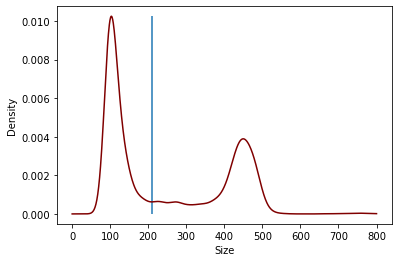

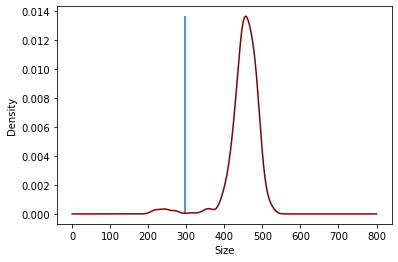

In [36]:
test1_flt, test1_flt2, test1_flt3, test1_flt4, test1_flt_bw, test1_bor, test1_bw = filter_size_EI_WL_size(test1,test1_opt)


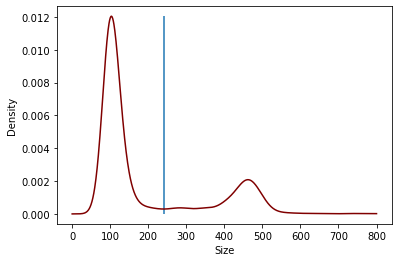

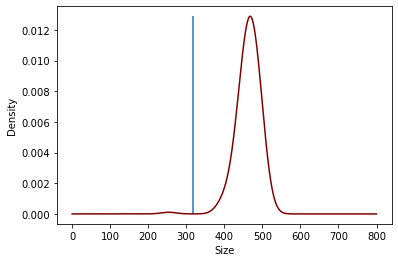

In [37]:
test2_flt, test2_flt2, test2_flt3, test2_flt4, test2_flt_bw, test2_bor, test2_bw = filter_size_EI_WL_size(test2,test2_opt)


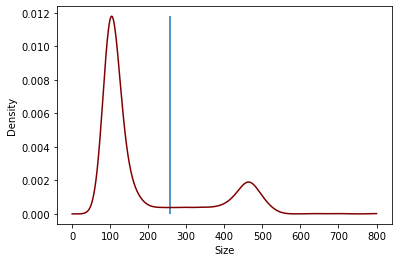

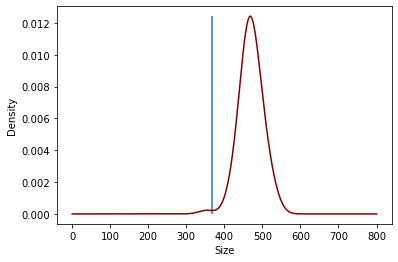

In [38]:
test3_flt, test3_flt2, test3_flt3, test3_flt4, test3_flt_bw, test3_bor, test3_bw = filter_size_EI_WL_size(test3,test3_opt)


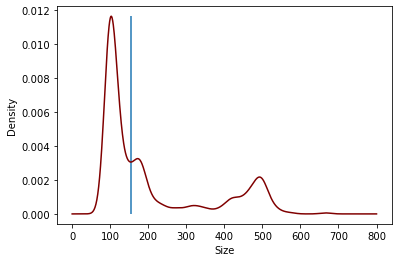

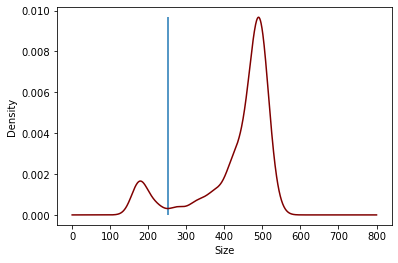

In [39]:
test4_flt, test4_flt2, test4_flt3, test4_flt4, test4_flt_bw, test4_bor, test4_bw = filter_size_EI_WL_size(test4,test4_opt)


## 4.3 Data visualization

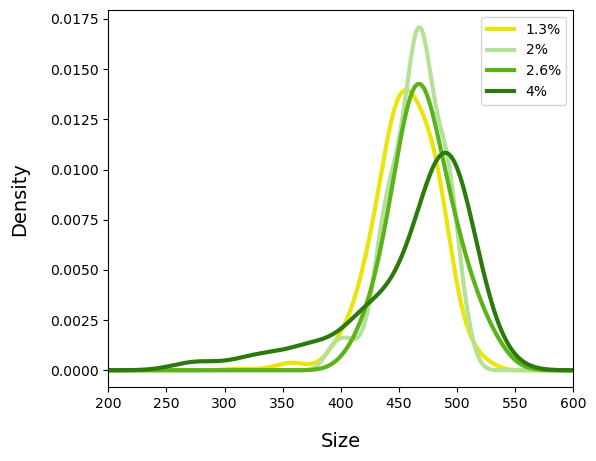

In [40]:
all_eg_data = [test1_flt4,test2_flt4,test3_flt4,test4_flt4]
all_bw = [test1_flt_bw,test2_flt_bw,test3_flt_bw,test4_flt_bw]
colors =  ['#EAE509','#B4E197','#5BB318','#2B7A0B']
labels = ['1.3%','2%','2.6%','4%']

fig , ax = plt.subplots(sharex=True, sharey=True,figsize=(6,5),dpi=100, facecolor='w', edgecolor='k')
for ind,eg_data in enumerate(all_eg_data):
    #reshape the numpy array of egg size data
    egre = np.array(eg_data['Size'])[:, np.newaxis]
    #generate some data within the range of egg size
    egre_plot = np.linspace(0, 1600, 1000)[:, np.newaxis]
    #Fit the Kernel Density model on the data.
    kde = KernelDensity(kernel='gaussian', bandwidth=all_bw[ind]).fit(egre)
    #Compute the log-likelihood of each sample under the model.
    log_dens = kde.score_samples(egre_plot)             
    ax.plot(egre_plot[:, 0], np.exp(log_dens), color=colors[ind], label=labels[ind], linewidth = 3)
    #plot the border between the two peaks
plt.xlabel('Size',size = 14,labelpad=15)
plt.ylabel('Density',size = 14,labelpad=15) 
plt.legend()  
plt.xlim(200,600)        
plt.savefig('../plots/final_plots/MC_treatment_filtered_dist.png', dpi=100,format='png', bbox_inches = 'tight')
plt.savefig('../plots/final_plots/MC_treatment_filtered_dist.svg', dpi=100,format='svg', bbox_inches = 'tight')


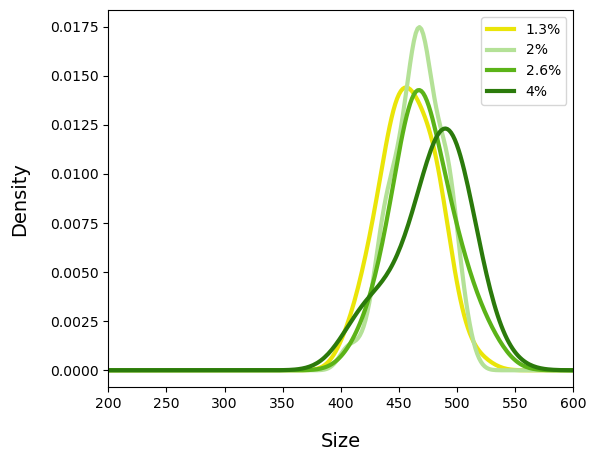

In [41]:
all_eg_data = [test1_flt4[test1_flt4['Size'] > 400],test2_flt4[test2_flt4['Size'] > 400],test3_flt4[test3_flt4['Size'] > 400],test4_flt4[test4_flt4['Size'] > 400]]
all_bw = [test1_flt_bw,test2_flt_bw,test3_flt_bw,test4_flt_bw]
colors =  ['#EAE509','#B4E197','#5BB318','#2B7A0B']
labels = ['1.3%','2%','2.6%','4%']

fig , ax = plt.subplots(sharex=True, sharey=True,figsize=(6,5),dpi=100, facecolor='w', edgecolor='k')
for ind,eg_data in enumerate(all_eg_data):
    #reshape the numpy array of egg size data
    egre = np.array(eg_data['Size'])[:, np.newaxis]
    #generate some data within the range of egg size
    egre_plot = np.linspace(0, 1600, 1000)[:, np.newaxis]
    #Fit the Kernel Density model on the data.
    kde = KernelDensity(kernel='gaussian', bandwidth=all_bw[ind]).fit(egre)
    #Compute the log-likelihood of each sample under the model.
    log_dens = kde.score_samples(egre_plot)             
    ax.plot(egre_plot[:, 0], np.exp(log_dens), color=colors[ind], label=labels[ind], linewidth = 3)
    #plot the border between the two peaks
plt.xlabel('Size',size = 14,labelpad=15)
plt.ylabel('Density',size = 14,labelpad=15) 
plt.legend()  
plt.xlim(200,600)        
plt.savefig('../plots/final_plots/MC_treatment_filtered_dist_above400.png', dpi=100,format='png', bbox_inches = 'tight')
plt.savefig('../plots/final_plots/MC_treatment_filtered_dist_above400.svg', dpi=100,format='svg', bbox_inches = 'tight')


In [42]:
print(np.median(test1_flt4['Size']))
print(np.median(test2_flt4['Size']))
print(np.median(test3_flt4['Size']))
print(np.median(test4_flt4['Size']))

458.50458649628666
466.58462676295056
468.60463682961654
477.3580137851692


In [43]:

print(np.median(test1_flt4[test1_flt4['Size'] > 400]['Size']))
print(np.median(test2_flt4[test2_flt4['Size'] > 400]['Size']))
print(np.median(test3_flt4[test3_flt4['Size'] > 400]['Size']))
print(np.median(test4_flt4[test4_flt4['Size'] > 400]['Size']))

458.50458649628666
466.58462676295056
468.60463682961654
486.11139074072173


## As the concentration of MC increases, the median estimated egg size increases. This is becuase the the sheath buffer becomes more viscous which will reduce the flow rate. The slower flow rate facilitates the alignment of objects along the long axis while passing through the laser path. 